# Setup
The following should install all the packages we need for this example

```shell
conda create --name ccl 
conda activate ccl 

conda install -c conda-forge jupyterlab
conda install -c conda-forge matplotlib
conda install -c conda-forge dask['distributed']
conda install -c conda-forge ipympl
conda install -c conda-forge nodejs

pip install opencv-python￼
pip install pyhdf

pip install connected-components-3d
conda install -c conda-forge proj4
conda install -c conda-forge basemap
```

In [1]:
%matplotlib widget
import cc3d
import netCDF4
import glob
import numpy
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib

In [4]:
import os
os.environ['PROJ_LIB'] = '~/miniconda3/envs/ccl/share/proj/'
from mpl_toolkits.basemap import Basemap

# Loading the data

In [5]:
def load_imerg(file_path, variable_name):
    netcdf = netCDF4.Dataset(file_path, 'r', format='NETCDF4')
    data = netcdf.groups['Grid'][variable_name][:][0].T[::-1]
    return data   

In [6]:
file_paths = sorted(glob.glob('../data/imerg/3B-HHR.MS.MRG.3IMERG*'))
variable_name = 'precipitationCal'

stack = []
for file_path in file_paths:
    data = load_imerg(file_path, variable_name)
    stack.append(data)
    
data = numpy.ma.array(stack)

# Thresholding and creating CCLs

In [7]:
thresh = 1
data[data<thresh] = 0
data[data>=thresh] = 1

In [8]:
connectivity = 26 
labels_out = cc3d.connected_components(data, connectivity=connectivity)

In [9]:
labels_out = cc3d.dust(labels_out, 
                       threshold=100, 
                       connectivity=connectivity, 
                       in_place=False)

In [10]:
labels_out = numpy.ma.array(labels_out, mask=data.mask)
labels_out = numpy.ma.masked_where(labels_out==0, labels_out)

In [11]:
largest, N = cc3d.largest_k(labels_out, 
                            k=10, 
                            connectivity=26, 
                            delta=0, 
                            return_N=True)

largest = numpy.ma.masked_where(largest==0, largest)

# Plotting

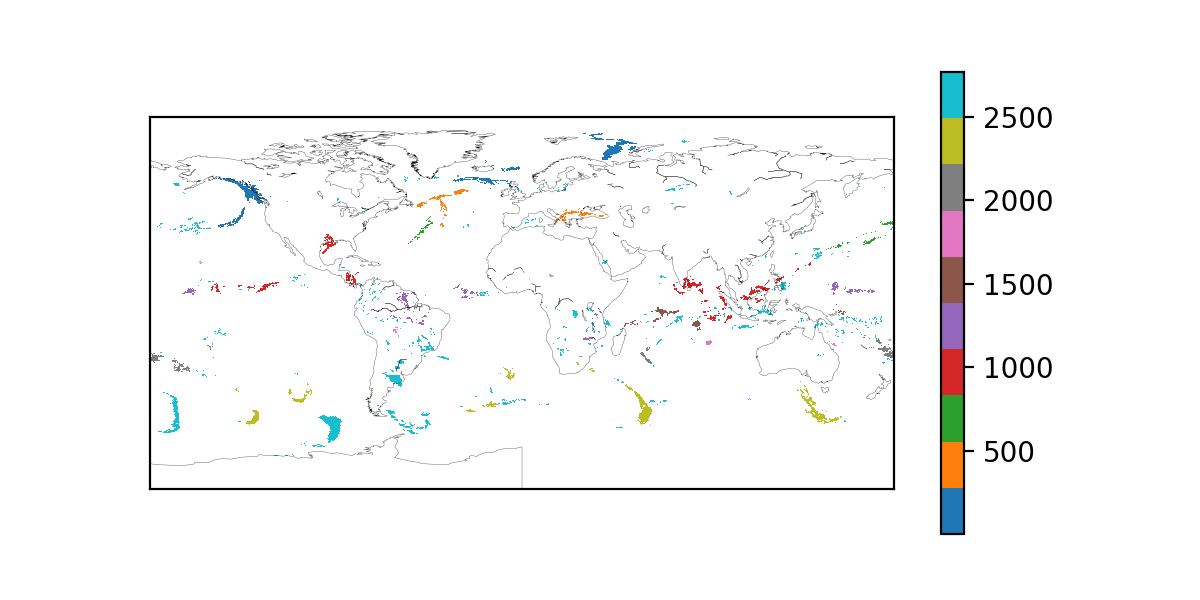

In [14]:
fig = plt.figure(figsize=(6, 3), dpi=200)
ax = fig.add_subplot(111)

m = Basemap(projection='cyl')
m.drawcoastlines(0.1)

plot_data = labels_out
im = ax.imshow(plot_data[0], 
                cmap='tab10',
                interpolation='none',
                extent=[-180, 180, -90,90])

def animate(i):    
    im.set_array(plot_data[i])
    return [im]

anim = animation.FuncAnimation(fig,
                               animate,                                
                               frames=len(plot_data),
                               interval=100, # in ms
                               blit=True)

plt.colorbar(im, ax=ax, orientation='vertical')
anim.save('all.gif', fps=10)

## Plotting the largest

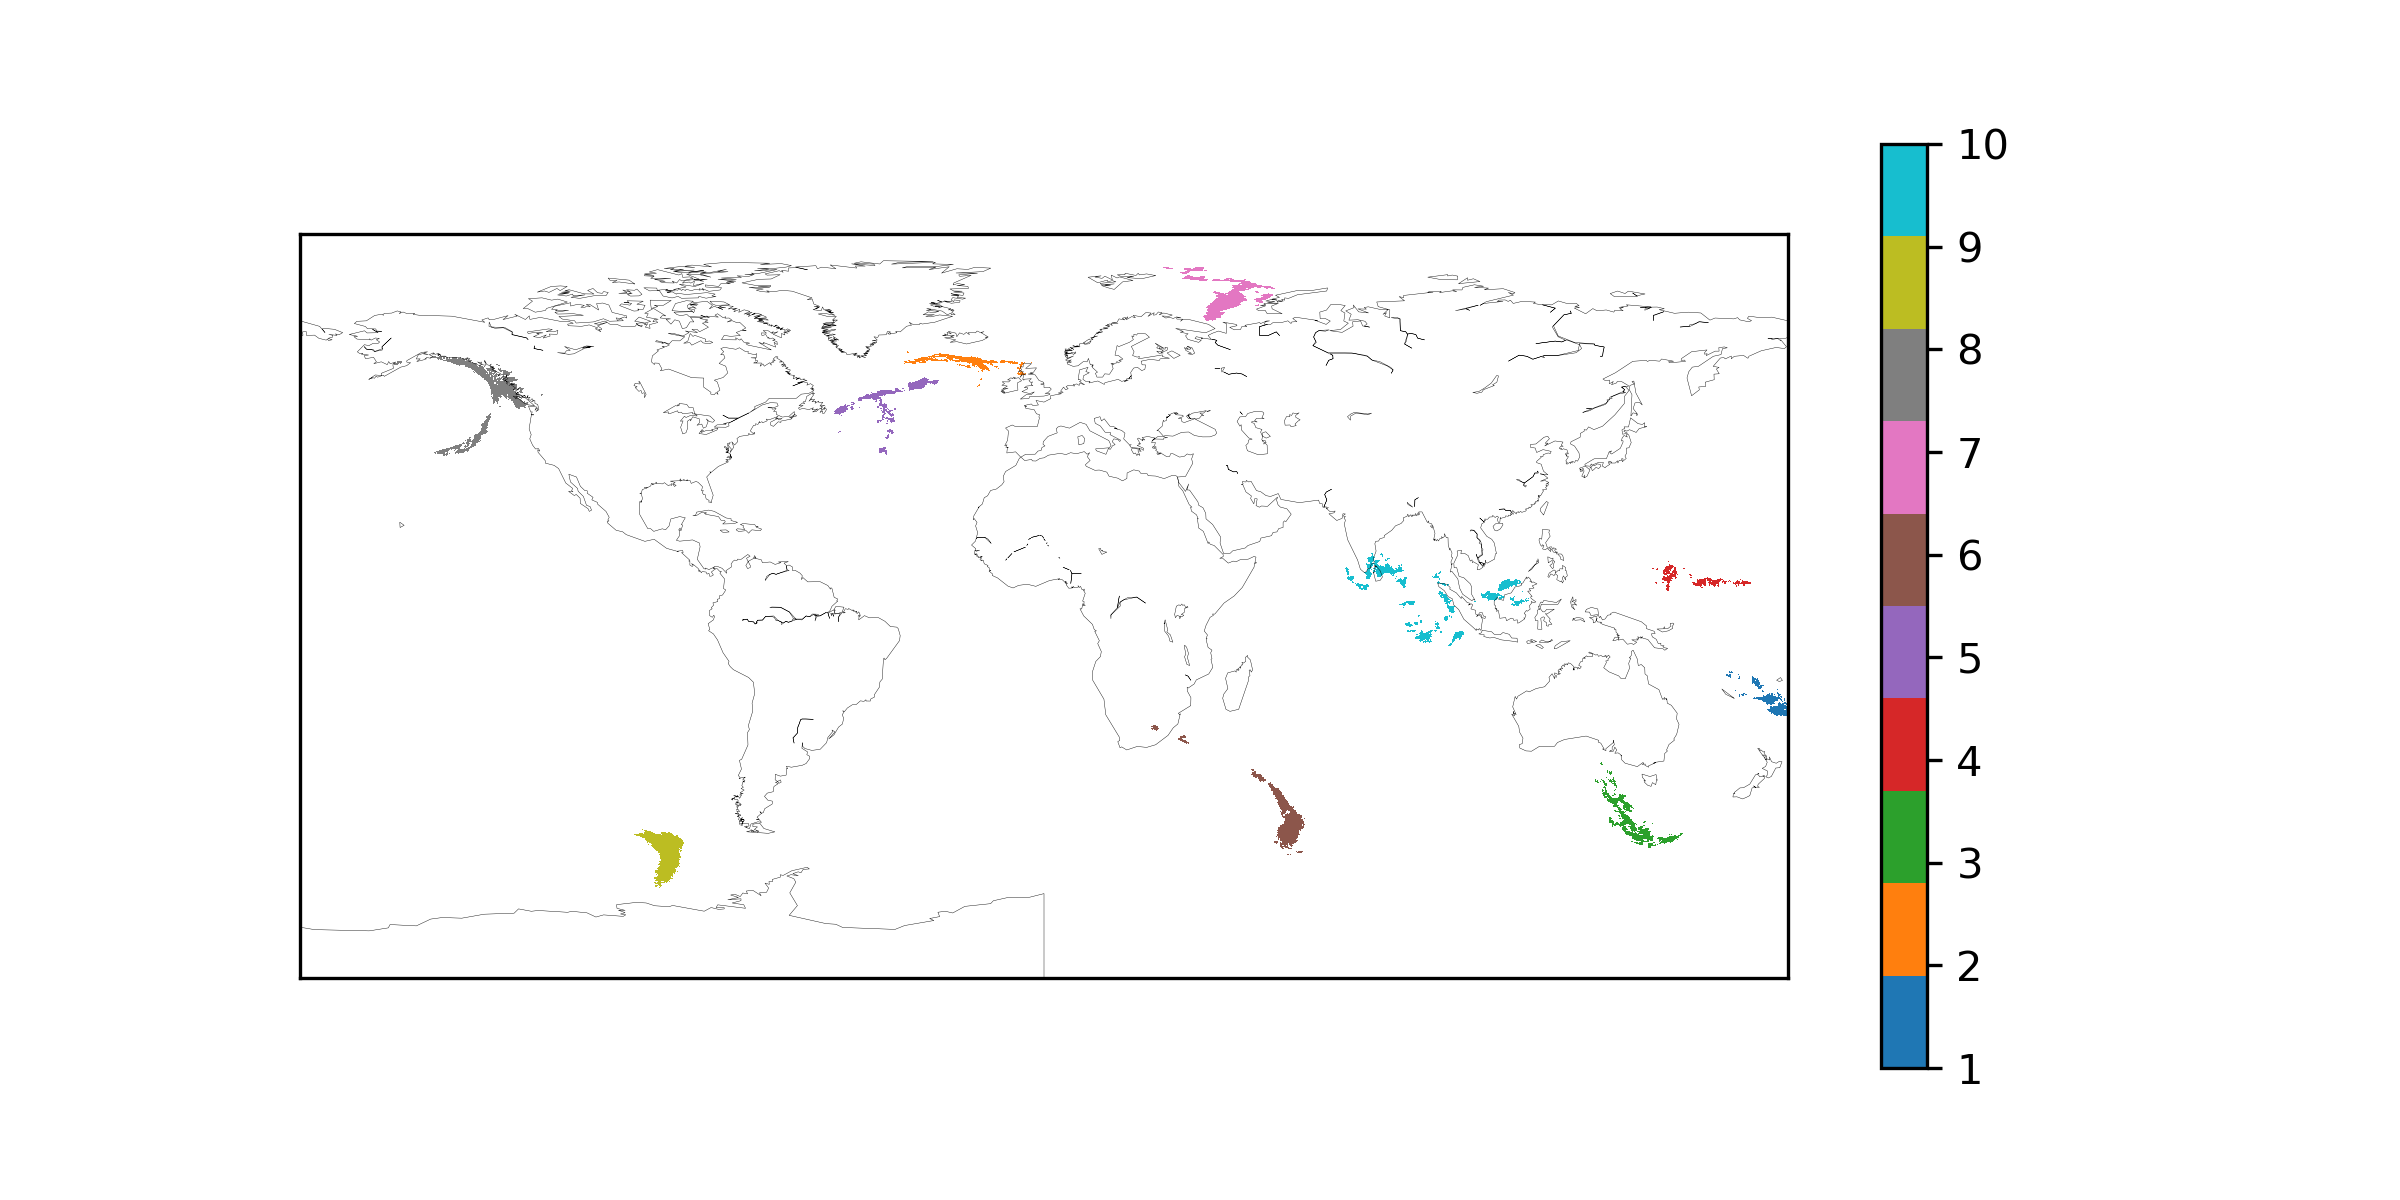

In [20]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_subplot(111)

m = Basemap(projection='cyl')
m.drawcoastlines(0.1)

plot_data = largest
im = ax.imshow(plot_data[0], 
                cmap='tab10',
                interpolation='none',
                extent=[-180, 180, -90,90])

def animate(i):    
    im.set_array(plot_data[i])
    return [im]

anim = animation.FuncAnimation(fig,
                               animate,                                
                               frames=len(plot_data),
                               interval=100, # in ms
                               blit=True)

plt.colorbar(im, ax=ax, orientation='vertical')
anim.save('10_largest.gif', fps=10)